<a href="https://colab.research.google.com/github/sujathachittiri/DM4ML/blob/main/Customer_Churn_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CSV Data Ingestion

In [2]:
import pandas as pd
import logging
import os
import sys

# Configure logging
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(filename=os.path.join(log_dir, 'data_ingestion.log'), level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))  # Print logs to console too

def load_data(file_path):
    """Loads customer churn dataset from a CSV file and logs the process."""
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Successfully loaded data from {file_path}")
        print("Dataset loaded successfully!")
        print("Shape:", df.shape)
        print("Columns:", df.columns.tolist())
        return df
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        print("Error loading dataset:", str(e))
        return None

def save_raw_data(df, output_path):
    """Saves raw data in a structured format."""
    try:
        raw_data_dir = "data/raw"
        os.makedirs(raw_data_dir, exist_ok=True)
        df.to_csv(output_path, index=False)
        logging.info(f"Raw data saved to {output_path}")
        print(f"Raw data saved to {output_path}")
    except Exception as e:
        logging.error(f"Error saving raw data: {e}")
        print("Error saving raw data:", str(e))

if __name__ == "__main__":
    file_path = "/content/sample_data/Customer_Churn_Dataset_Input.csv"
    output_path = "data/raw/customer_churn.csv"
    df = load_data(file_path)
    if df is not None:
        save_raw_data(df, output_path)


Successfully loaded data from /content/sample_data/Customer_Churn_Dataset_Input.csv
Dataset loaded successfully!
Shape: (10000, 13)
Columns: ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Raw data saved to data/raw/customer_churn.csv
Raw data saved to data/raw/customer_churn.csv


#Kaggle API Data Ingestion

In [3]:
import os
import logging
from kaggle.api.kaggle_api_extended import KaggleApi

def setup_logging():
    """Configures logging for API data ingestion."""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(filename=os.path.join(log_dir, 'api_data_ingestion_kaggle.log'), level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def download_kaggle_dataset(dataset_name, output_folder="data/raw"):
    """Downloads a dataset from Kaggle and stores it in the raw data folder."""
    os.makedirs(output_folder, exist_ok=True)
    api = KaggleApi()
    api.authenticate()

    logging.info(f"Downloading Kaggle dataset: {dataset_name}")
    api.dataset_download_files(dataset_name, path=output_folder, unzip=True)
    logging.info(f"Dataset {dataset_name} downloaded successfully.")
    print(f"Dataset {dataset_name} downloaded successfully.")

if __name__ == "__main__":
    setup_logging()
    kaggle_dataset = "blastchar/telco-customer-churn"  # Example dataset (Telco Customer Churn)
    download_kaggle_dataset(kaggle_dataset)


Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
Dataset blastchar/telco-customer-churn downloaded successfully.


#Raw Data Storage

In [4]:
import os
import shutil
from datetime import datetime

def create_storage_structure(base_dir="data_lake"):
    """Creates a structured local storage system for ingested data."""
    sub_dirs = ["raw/csv", "raw/kaggle_api", "processed", "models", "logs"]

    for sub in sub_dirs:
        path = os.path.join(base_dir, sub)
        os.makedirs(path, exist_ok=True)
        print(f"Created directory: {path}")

    return base_dir

def move_to_storage(source_file, storage_type, base_dir="data_lake"):
    """Moves an ingested file to the appropriate storage partition."""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    dest_dir = os.path.join(base_dir, "raw", storage_type, timestamp)
    os.makedirs(dest_dir, exist_ok=True)

    if storage_type == "csv":
        file_name = os.path.basename(source_file)
    elif storage_type == "kaggle_api":
        file_name = "kaggle_churn.csv"
    #file_name = os.path.basename(source_file)
    dest_path = os.path.join(dest_dir, file_name)

    shutil.copy(source_file, dest_path)
    print(f"Copied {source_file} to {dest_path}")
    return dest_path

if __name__ == "__main__":
    base_dir = create_storage_structure()

    # Example usage (assuming ingestion scripts save files in 'data/raw/')
    sample_csv = "data/raw/customer_churn.csv"
    sample_api = "data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"

    move_to_storage(sample_csv, "csv", base_dir)
    move_to_storage(sample_api, "kaggle_api", base_dir)


Created directory: data_lake/raw/csv
Created directory: data_lake/raw/kaggle_api
Created directory: data_lake/processed
Created directory: data_lake/models
Created directory: data_lake/logs
Copied data/raw/customer_churn.csv to data_lake/raw/csv/20250313_055836/customer_churn.csv
Copied data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv to data_lake/raw/kaggle_api/20250313_055836/kaggle_churn.csv


#Data Validation

In [5]:
import pandas as pd
import logging
import os
import glob
import numpy as np

def setup_logging():
    """Configures logging for data validation."""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(filename=os.path.join(log_dir, 'data_validation.log'), level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def get_latest_file(directory, file_pattern):
    """Finds the most recent file in a dynamically created directory."""
    subdirs = sorted(glob.glob(os.path.join(directory, "*/")), reverse=True)
    for subdir in subdirs:
        file_path = os.path.join(subdir, file_pattern)
        if os.path.exists(file_path):
            return file_path
    return None

def validate_data(df, source):
    """Performs data validation checks and logs issues with suggested solutions."""
    validation_results = []

    # Check for missing values
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0].to_dict()
    if missing_cols:
        validation_results.append((f"{source} - Missing Values", str(missing_cols), "Fill missing values using mean/median or remove rows"))
        logging.warning(f"{source} has missing values: {missing_cols}")
    else:
        logging.info(f"No missing values found in {source}")

    # Validate data types
    data_types = df.dtypes.to_dict()
    validation_results.append((f"{source} - Data Types", str(data_types), "Ensure correct data types: Convert categorical to string, numerical to float/int if needed"))
    logging.info(f"Validated data types for {source}")

    # Check for duplicate records
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        validation_results.append((f"{source} - Duplicate Records", duplicate_count, "Remove duplicate records to avoid redundancy"))
        logging.warning(f"{source} has {duplicate_count} duplicate records")
    else:
        logging.info(f"No duplicate records found in {source}")

    # Validate numerical ranges and detect outliers using Mean & Standard Deviation
    for col in df.select_dtypes(include=['number']).columns:
        min_val, max_val = df[col].min(), df[col].max()
        mean_val, std_val = df[col].mean(), df[col].std()
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]

        validation_results.append((f"{source} - Range for {col}", str({"min": min_val, "max": max_val}), "Ensure values are within expected range"))
        if outlier_count > 0:
            validation_results.append((f"{source} - Outliers in {col}", outlier_count, "Investigate and cap extreme values if necessary"))
            logging.warning(f"{source} has {outlier_count} outliers in {col}")

    return validation_results

def generate_validation_report(results, output_file="data_lake/processed/data_quality_report.csv"):
    """Saves validation results as a CSV report with suggested solutions."""
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    df_report = pd.DataFrame(results, columns=["Check", "Result", "Suggested Solution"])
    df_report.to_csv(output_file, index=False)
    logging.info(f"Data quality report saved to {output_file}")
    print(f"Data quality report saved to {output_file}")

if __name__ == "__main__":
    setup_logging()

    # Get latest stored customer churn data
    churn_file_path = get_latest_file("data_lake/raw/csv", "customer_churn.csv")
    if churn_file_path:
        df_churn = pd.read_csv(churn_file_path)
        results_churn = validate_data(df_churn, "Customer Churn Data")
    else:
        logging.error("No recent Customer Churn file found.")
        results_churn = []

    # Get latest stored API data
    api_file_path = get_latest_file("data_lake/raw/kaggle_api", "api_data.csv")
    if api_file_path:
        df_api = pd.read_csv(api_file_path)
        results_api = validate_data(df_api, "API Data")
    else:
        logging.error("No recent API data file found.")
        results_api = []

    # Combine results and generate report
    final_results = results_churn + results_api
    generate_validation_report(final_results)


Data quality report saved to data_lake/processed/data_quality_report.csv


#Data Preparation and Visualization

<ipython-input-6-86c09dffa6ca>:51: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
<ipython-input-6-86c09dffa6ca>:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-6-86c09dffa6ca>:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplac

Cleaned data saved to data_lake/processed/cleaned_data_local.csv


<ipython-input-6-86c09dffa6ca>:51: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
<ipython-input-6-86c09dffa6ca>:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True) # Fill NaNs with median


Cleaned data saved to data_lake/processed/cleaned_data_kaggle.csv


<Figure size 1200x600 with 0 Axes>

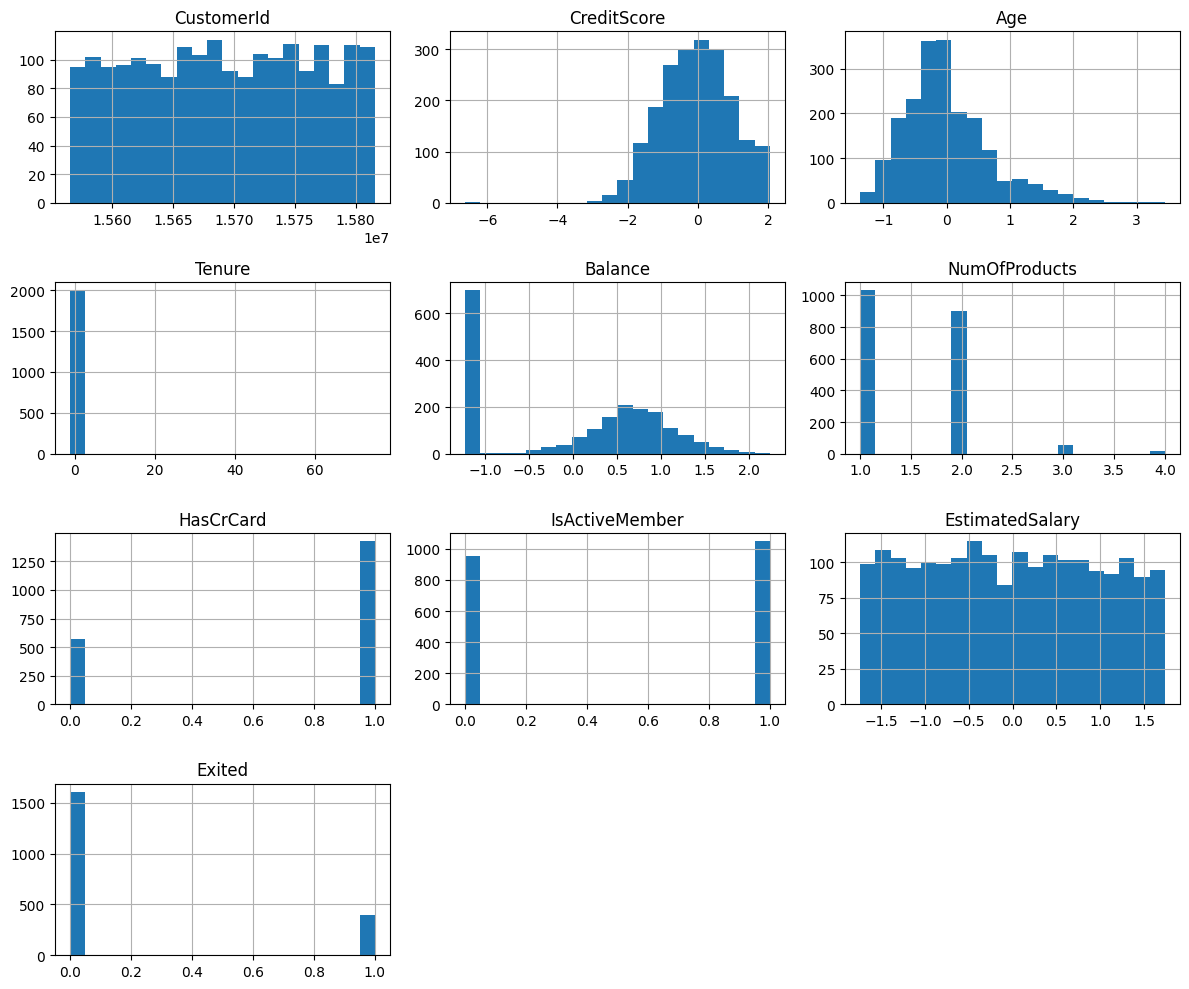

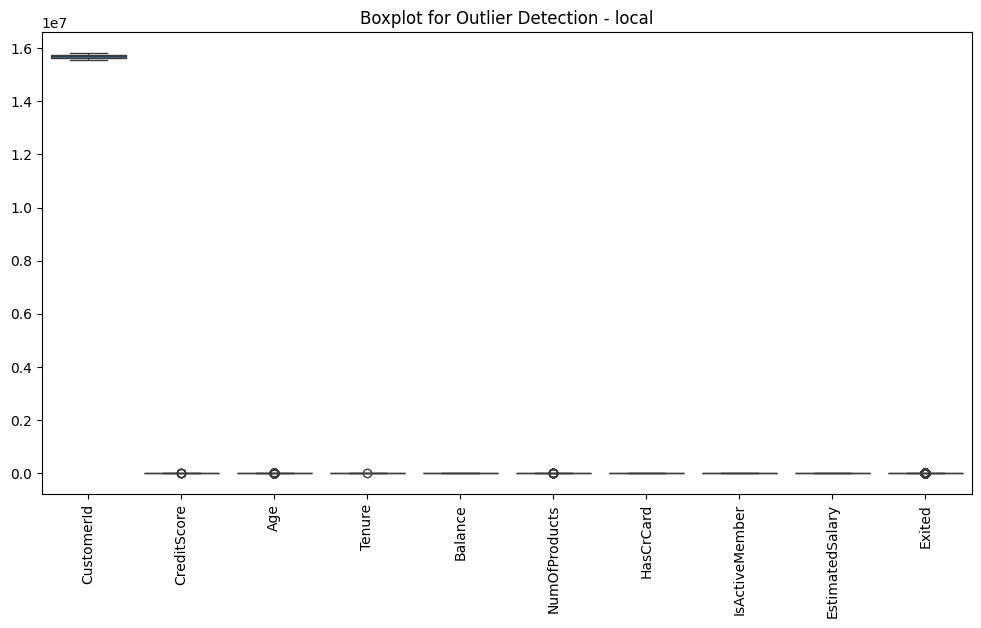

<Figure size 1200x600 with 0 Axes>

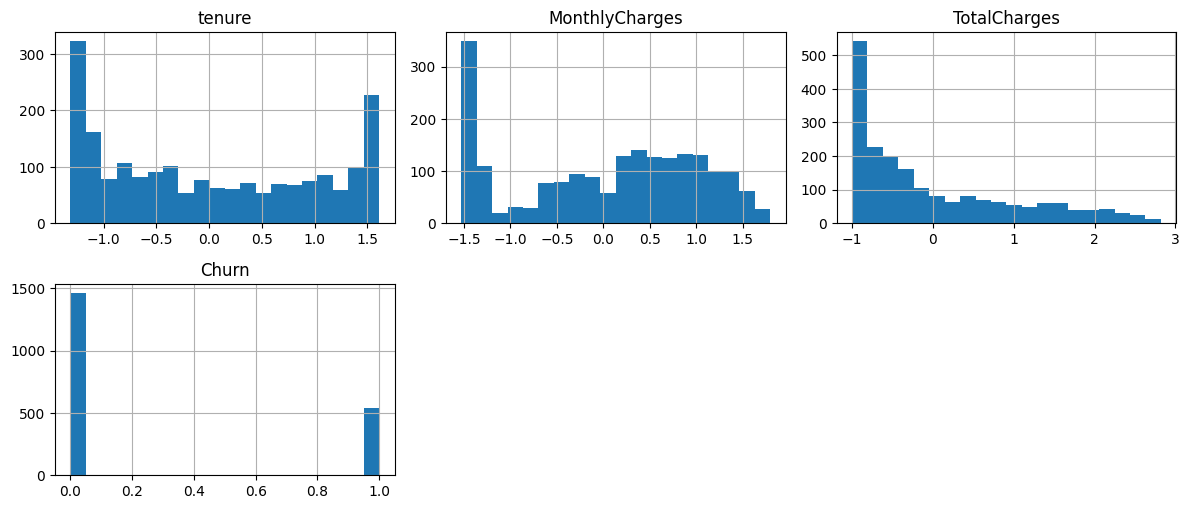

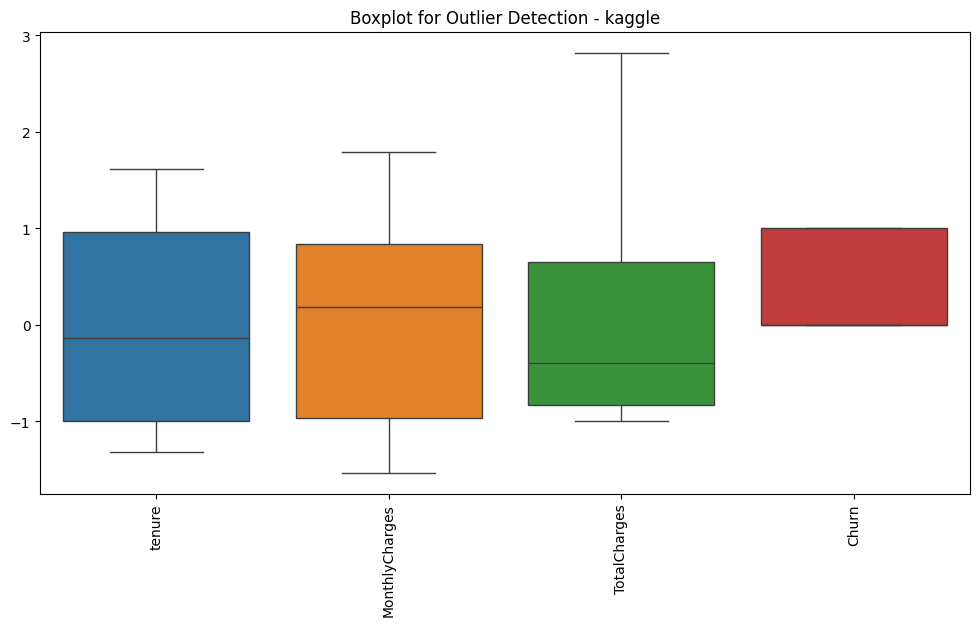

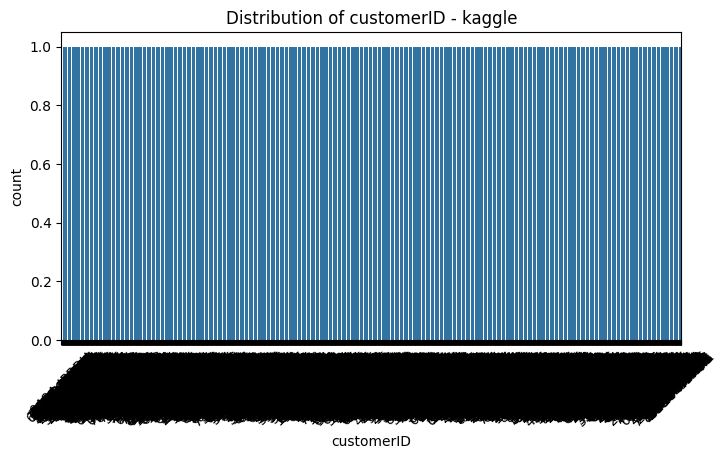

In [6]:
import pandas as pd
import numpy as np
import logging
import os
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def setup_logging():
    """Configures logging for data preparation."""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(filename=os.path.join(log_dir, 'data_preparation.log'), level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def get_latest_file(directory, file_pattern):
    """Finds the most recent file in a dynamically created directory."""
    subdirs = sorted(glob.glob(os.path.join(directory, "*/")), reverse=True)
    for subdir in subdirs:
        file_path = os.path.join(subdir, file_pattern)
        if os.path.exists(file_path):
            return file_path
    return None

def load_latest_data():
    """Loads the latest processed data for preparation from both local churn and Kaggle API datasets in chunks."""
    local_file = get_latest_file("data_lake/raw/csv", "customer_churn.csv")
    kaggle_file = get_latest_file("data_lake/raw/kaggle_api", "kaggle_churn.csv")

    chunk_size = 10000  # Read in chunks to avoid memory overload
    df_local = pd.concat(pd.read_csv(local_file, low_memory=True, chunksize=chunk_size)) if local_file else None
    df_kaggle = pd.concat(pd.read_csv(kaggle_file, low_memory=True, chunksize=chunk_size)) if kaggle_file else None

    if df_local is None:
        logging.error("No recent local customer churn data found.")
    if df_kaggle is None:
        logging.error("No recent Kaggle churn data found.")

    return df_local, df_kaggle

def process_dataset(df, dataset_name):
    """Cleans, encodes, and standardizes the dataset separately."""
    if df is None:
        logging.error(f"{dataset_name} dataset not available.")
        return None

    # Convert numeric columns stored as objects
    for col in df.columns:
        if df[col].dtype == 'object' and col not in ['customerID', 'TotalCharges']:
            df[col] = pd.to_numeric(df[col], errors='ignore')

    # Handle missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
    logging.info(f"Handled missing values for {dataset_name} dataset.")

    # Identify categorical columns for One-Hot Encoding, excluding customerID and TotalCharges
    categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod','Geography',
                        'Gender']
    categorical_cols = [col for col in categorical_cols if col in df.columns] # Filter columns that actually exist in df
    # Encode categorical variables using One-Hot Encoding
    if categorical_cols:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    logging.info(f"Categorical variables encoded using One-Hot Encoding for {dataset_name} dataset.")

    # Standardize numerical variables
    scaler = StandardScaler()
    numeric_cols = ['tenure','Tenure', 'MonthlyCharges', 'TotalCharges','CreditScore','Age','Balance','EstimatedSalary']
    numeric_cols = [col for col in numeric_cols if col in df.columns] # Filter columns that actually exist in df
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Invalid values become NaN
        df[col].fillna(df[col].median(), inplace=True) # Fill NaNs with median
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    if 'Churn' in df.columns:
        df["Churn"] = df["Churn"].map({'Yes': 1, 'No': 0})
    if 'Surname' in df.columns:
        df.drop('Surname', axis=1, inplace=True)
    logging.info(f"Numerical variables standardized for {dataset_name} dataset.")

    return df

def visualize_data(df, dataset_name):
    """Generates visualizations for data exploration while minimizing memory usage."""
    os.makedirs("data_lake/processed", exist_ok=True)
    df_sample = df.sample(n=min(2000, len(df)), random_state=42)  # Further reduce sample size to 2000

    # Plot numerical features separately
    numeric_cols = df_sample.select_dtypes(include=['number']).columns.tolist()
    plt.figure(figsize=(12, 6))
    df_sample[numeric_cols].hist(figsize=(12, 10), bins=20, layout=(4, 3))
    plt.tight_layout()
    plt.savefig(f"data_lake/processed/numeric_distribution_{dataset_name}.png")
    logging.info(f"Generated histogram for numerical features in {dataset_name} dataset.")

    # Boxplot for numerical features
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_sample[numeric_cols])
    plt.xticks(rotation=90)
    plt.title(f"Boxplot for Outlier Detection - {dataset_name}")
    plt.savefig(f"data_lake/processed/boxplot_{dataset_name}.png")
    logging.info(f"Generated boxplot for numerical features in {dataset_name} dataset.")

    # Plot categorical features separately
    categorical_cols = df_sample.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df_sample[col])
        plt.xticks(rotation=45)
        plt.title(f"Distribution of {col} - {dataset_name}")
        plt.savefig(f"data_lake/processed/categorical_{col}_{dataset_name}.png")
        logging.info(f"Generated count plot for {col} in {dataset_name} dataset.")

def save_cleaned_data(df, dataset_name):
    """Saves the cleaned dataset separately for each source."""
    output_file = f"data_lake/processed/cleaned_data_{dataset_name}.csv"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    df.to_csv(output_file, index=False)
    logging.info(f"Cleaned data saved to {output_file}")
    print(f"Cleaned data saved to {output_file}")

if __name__ == "__main__":
    setup_logging()
    df_local, df_kaggle = load_latest_data()

    # Process and save the local churn dataset
    if df_local is not None:
        df_local = process_dataset(df_local, "local")
        visualize_data(df_local, "local")
        save_cleaned_data(df_local, "local")

    # Process and save the Kaggle churn dataset
    if df_kaggle is not None:
        df_kaggle = process_dataset(df_kaggle, "kaggle")
        visualize_data(df_kaggle, "kaggle")
        save_cleaned_data(df_kaggle, "kaggle")


#Transformation and Storage in SQL DB

In [7]:
import pandas as pd
import numpy as np
import logging
import os
import sqlite3

def setup_logging():
    """Configures logging for data transformation."""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(filename=os.path.join(log_dir, 'data_transformation.log'), level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def load_cleaned_data():
    """Loads the latest cleaned datasets for transformation."""
    local_file = "data_lake/processed/cleaned_data_local.csv"
    kaggle_file = "data_lake/processed/cleaned_data_kaggle.csv"

    df_local = pd.read_csv(local_file) if os.path.exists(local_file) else None
    df_kaggle = pd.read_csv(kaggle_file) if os.path.exists(kaggle_file) else None

    return df_local, df_kaggle

def feature_engineering(df, dataset_name):
    """Creates new aggregated and derived features safely by checking column availability."""
    if df is None:
        logging.warning(f"No data available for {dataset_name}.")
        return None

    if dataset_name == "local":
        # Local dataset transformations
        if {'Balance', 'NumOfProducts'}.issubset(df.columns):
            df['TotalBalance'] = df['Balance'] * df['NumOfProducts']
        else:
            logging.warning(f"Skipping TotalBalance for {dataset_name} as required columns are missing.")

        if {'Tenure', 'NumOfProducts'}.issubset(df.columns):
            df['TenurePerProduct'] = df['Tenure'] / (df['NumOfProducts'] + 1)
        else:
            logging.warning(f"Skipping TenurePerProduct for {dataset_name} as required columns are missing.")

        if {'IsActiveMember', 'HasCrCard'}.issubset(df.columns):
            df['ActivityScore'] = df['IsActiveMember'] * df['HasCrCard']
        else:
            logging.warning(f"Skipping ActivityScore for {dataset_name} as required columns are missing.")

    elif dataset_name == "kaggle":
        # Kaggle dataset transformations
        if {'MonthlyCharges', 'tenure'}.issubset(df.columns):
            df['AvgMonthlySpend'] = df['MonthlyCharges'] * df['tenure']
        else:
            logging.warning(f"Skipping AvgMonthlySpend for {dataset_name} as required columns are missing.")

        if {'TotalCharges', 'tenure'}.issubset(df.columns):
            df['ChargePerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)
        else:
            logging.warning(f"Skipping ChargePerMonth for {dataset_name} as required columns are missing.")

    logging.info(f"Feature engineering applied to {dataset_name} dataset.")
    return df

def store_in_database(df, dataset_name):
    """Stores the transformed data in an SQLite database."""
    db_path = "data_lake/database/customer_churn.db"
    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    conn = sqlite3.connect(db_path)
    table_name = f"churn_{dataset_name}"
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()

    logging.info(f"Stored {dataset_name} dataset in database table {table_name}.")
    print(f"Stored {dataset_name} dataset in database table {table_name}.")

def generate_sample_queries():
    """Creates sample SQL queries for transformed data retrieval."""
    queries = [
        "SELECT * FROM churn_local LIMIT 10;",
        "SELECT * FROM churn_kaggle LIMIT 10;",
        "SELECT CustomerId, TotalBalance FROM churn_local WHERE TotalBalance > 50000;",
        "SELECT AVG(ChargePerMonth) FROM churn_kaggle;"
    ]

    os.makedirs("data_lake/database", exist_ok=True)
    with open("data_lake/database/sample_queries.sql", "w") as f:
        for query in queries:
            f.write(query + "\n")

    logging.info("Sample SQL queries saved.")
    print("Sample SQL queries saved.")

def save_summary():
    """Saves a summary of the transformation logic."""
    summary = """
    Data Transformation Summary:
    - Local dataset:
      - Created 'TotalBalance' = Balance * NumOfProducts
      - Created 'TenurePerProduct' = Tenure / (NumOfProducts + 1)
      - Created 'ActivityScore' = IsActiveMember * HasCrCard
    - Kaggle dataset:
      - Created 'AvgMonthlySpend' = MonthlyCharges * tenure
      - Created 'ChargePerMonth' = TotalCharges / (tenure + 1)
    - Transformed data stored in SQLite database with tables: churn_local, churn_kaggle
    - Sample queries provided in 'data_lake/database/sample_queries.sql'
    """
    os.makedirs("data_lake/documentation", exist_ok=True)
    with open("data_lake/documentation/transformation_summary.txt", "w") as f:
        f.write(summary)
    logging.info("Transformation summary saved.")
    print("Transformation summary saved.")

if __name__ == "__main__":
    setup_logging()
    df_local, df_kaggle = load_cleaned_data()

    if df_local is not None:
        df_local = feature_engineering(df_local, "local")
        store_in_database(df_local, "local")

    if df_kaggle is not None:
        df_kaggle = feature_engineering(df_kaggle, "kaggle")
        store_in_database(df_kaggle, "kaggle")

    generate_sample_queries()
    save_summary()


Stored local dataset in database table churn_local.
Stored kaggle dataset in database table churn_kaggle.
Sample SQL queries saved.
Transformation summary saved.


#Feature Store

In [8]:
import os
import logging
import pandas as pd
import sqlite3
from feast import FeatureStore, FeatureView, Entity, Field
from feast.infra.offline_stores.file_source import FileSource
from feast.types import Float32, Int64, ValueType

def setup_logging():
    """Configures logging for feature store setup."""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(filename=os.path.join(log_dir, 'feature_store.log'), level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def load_transformed_data(table_name):
    """Loads the transformed datasets from SQLite database."""
    db_path = "data_lake/database/customer_churn.db"
    if not os.path.exists(db_path):
        logging.error("Database file not found.")
        return None

    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()

    return df

def configure_feature_store(df, table_name):
    """Configures and initializes the feature store with dataset-specific fields."""
    os.makedirs("feature_store", exist_ok=True)


    if table_name == "churn_local":

        entity = Entity(name="CustomerId", value_type=ValueType.INT64)
        features = [
            Field(name="TotalBalance", dtype=Float32),
            Field(name="TenurePerProduct", dtype=Float32),
            Field(name="ActivityScore", dtype=Float32)
        ]
    elif table_name == "churn_kaggle":
        entity = Entity(name="customerID", value_type=ValueType.INT64)
        features = [
            Field(name="AvgMonthlySpend", dtype=Float32),
            Field(name="ChargePerMonth", dtype=Float32)
        ]
    else:
        logging.error(f"Unknown dataset: {table_name}")
        return

    source = FileSource(
        path=f"data_lake/processed/cleaned_data_{table_name}.csv",
        event_timestamp_column="event_timestamp"  # Replace with your event timestamp column if available
    )

    feature_view = FeatureView(
        name=f"{table_name}_features",
        entities=[entity],
        ttl=None,
        schema=features,
        source=source
    )

    with open(f"feature_store/feature_metadata_{table_name}.txt", "w") as f:
        f.write("Feature Metadata:\n")
        if table_name == "churn_local":
            f.write("TotalBalance - Customer total balance (Balance * NumOfProducts)\n")
            f.write("TenurePerProduct - Tenure divided by number of products\n")
            f.write("ActivityScore - IsActiveMember * HasCrCard\n")
        elif table_name == "churn_kaggle":
            f.write("AvgMonthlySpend - Monthly Charges multiplied by tenure\n")
            f.write("ChargePerMonth - Total Charges divided by tenure\n")

    logging.info(f"Feature store configured for {table_name}.")
    print(f"Feature store configured for {table_name}.")

def save_sample_feature_retrieval(table_name):
    """Saves a sample feature retrieval query specific to each dataset."""
    if table_name == "churn_local":
        query = f"""
        SELECT CustomerId, TotalBalance, TenurePerProduct, ActivityScore
        FROM {table_name}
        WHERE TotalBalance > 50000;
        """
    elif table_name == "churn_kaggle":
        query = f"""
        SELECT customerID, AvgMonthlySpend, ChargePerMonth
        FROM {table_name}
        WHERE ChargePerMonth > 50;
        """
    else:
        logging.error(f"Unknown dataset: {table_name}")
        return

    os.makedirs("feature_store/queries", exist_ok=True)
    with open(f"feature_store/queries/sample_query_{table_name}.sql", "w") as f:
        f.write(query)

    logging.info(f"Sample feature retrieval query saved for {table_name}.")
    print(f"Sample feature retrieval query saved for {table_name}.")

if __name__ == "__main__":
    setup_logging()

    for dataset in ["churn_kaggle", "churn_local"]:
        df = load_transformed_data(dataset)
        if df is not None:
            configure_feature_store(df, dataset)
            save_sample_feature_retrieval(dataset)


Feature store configured for churn_kaggle.
Sample feature retrieval query saved for churn_kaggle.
Feature store configured for churn_local.
Sample feature retrieval query saved for churn_local.


#Model Training

In [10]:
import os
import logging
import pickle
import pandas as pd
import sqlite3
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def setup_logging():
    """Configures logging for model training."""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(filename=os.path.join(log_dir, 'model_training.log'), level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def load_data():
    """Loads processed datasets from SQLite database."""
    db_path = "data_lake/database/customer_churn.db"
    conn = sqlite3.connect(db_path)
    df_local = pd.read_sql_query("SELECT * FROM churn_local", conn)
    df_kaggle = pd.read_sql_query("SELECT * FROM churn_kaggle", conn)
    conn.close()

    return df_local, df_kaggle

def identify_columns(df, dataset_name):
    """Identifies the correct ID and target variable columns for each dataset."""
    if dataset_name == "local":
        id_column = "CustomerId"
        target_column = "Exited"
        surname_column = "Surname"
    elif dataset_name == "kaggle":
        id_column = "customerID"
        target_column = "Churn"
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    return id_column, target_column

def prepare_data(df, dataset_name):
    """Prepares data for model training by splitting into train and test sets."""
    id_column, target_column = identify_columns(df, dataset_name)

    if dataset_name == "kaggle":
        surname_column = "Surname"
    else:
        surname_column = None
    X = df.drop(columns=[id_column, target_column, surname_column], errors='ignore')  # Remove ID & target variable
    y = df[target_column] if target_column in df.columns else None

    if y is None:
        raise ValueError(f"Target variable '{target_column}' not found in {dataset_name} dataset.")

    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name, dataset_name):
    """Trains the given model and evaluates its performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    logging.info(f"{model_name} Performance: {metrics}")
    print(f"{model_name} Performance: {metrics}")

    # Save performance report
    report_dir = "reports"
    os.makedirs(report_dir, exist_ok=True)
    report_path = os.path.join(report_dir, f"performance_report_{model_name}_{dataset_name}.csv")
    pd.DataFrame([metrics]).to_csv(report_path, index=False)
    logging.info(f"Performance report saved: {report_path}")
    print(f"Performance report saved: {report_path}")

    return model, metrics

def save_model(model, model_name):
    """Saves the trained model using MLflow and Pickle."""
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{model_name}.pkl")

    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

    mlflow.sklearn.log_model(model, model_name)
    logging.info(f"Model saved: {model_path}")
    print(f"Model saved: {model_path}")

def train_models():
    """Trains multiple models on both datasets."""
    df_local, df_kaggle = load_data()

    for dataset_name, df in zip(["local", "kaggle"], [df_local, df_kaggle]):
        try:
            X_train, X_test, y_train, y_test = prepare_data(df, dataset_name)

            # Train and evaluate models
            rf_model, rf_metrics = train_and_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(), f"RandomForest_{dataset_name}", dataset_name)
            lr_model, lr_metrics = train_and_evaluate(X_train, X_test, y_train, y_test, LogisticRegression(max_iter=1000), f"LogisticRegression_{dataset_name}", dataset_name)

            # Save models
            save_model(rf_model, f"RandomForest_{dataset_name}")
            save_model(lr_model, f"LogisticRegression_{dataset_name}")

        except ValueError as e:
            logging.error(f"Error processing {dataset_name}: {e}")
            print(f"Error processing {dataset_name}: {e}")

if __name__ == "__main__":
    setup_logging()
    train_models()


RandomForest_local Performance: {'accuracy': 0.867, 'precision': 0.757085020242915, 'recall': 0.4758269720101781, 'f1_score': 0.584375}
Performance report saved: reports/performance_report_RandomForest_local_local.csv
LogisticRegression_local Performance: {'accuracy': 0.8225, 'precision': 0.6233766233766234, 'recall': 0.24427480916030533, 'f1_score': 0.3510054844606947}
Performance report saved: reports/performance_report_LogisticRegression_local_local.csv


2025/03/13 06:25:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/RandomForest_local.pkl


2025/03/13 06:25:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/LogisticRegression_local.pkl
RandomForest_kaggle Performance: {'accuracy': 0.7934705464868701, 'precision': 0.6518518518518519, 'recall': 0.4718498659517426, 'f1_score': 0.5474339035769828}
Performance report saved: reports/performance_report_RandomForest_kaggle_kaggle.csv
LogisticRegression_kaggle Performance: {'accuracy': 0.8204400283889283, 'precision': 0.6851851851851852, 'recall': 0.5951742627345844, 'f1_score': 0.6370157819225251}
Performance report saved: reports/performance_report_LogisticRegression_kaggle_kaggle.csv


2025/03/13 06:25:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/RandomForest_kaggle.pkl


2025/03/13 06:25:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/LogisticRegression_kaggle.pkl
